[*********************100%***********************]  1 of 1 completed


--- Strategy Metrics: SPY ---
Max Drawdown: -15.70%


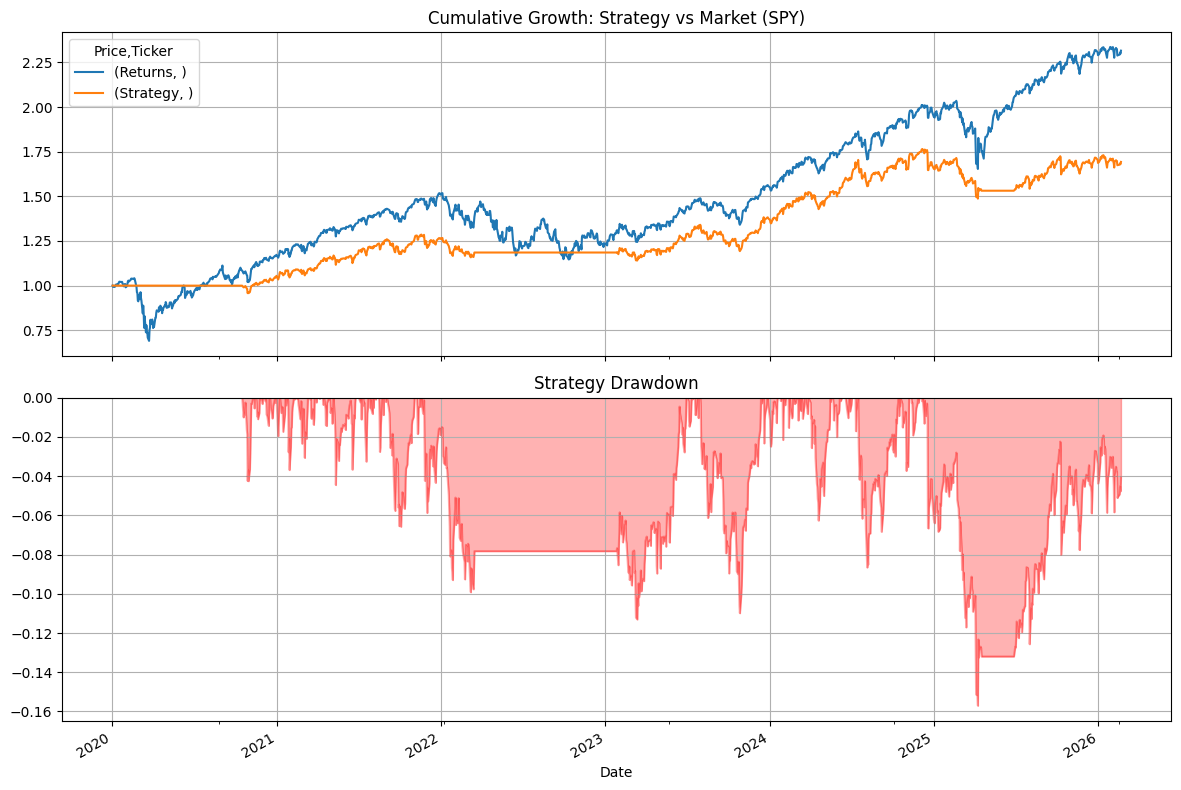

In [6]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

class VolTargetMomentum:
    def __init__(self, ticker, target_annual_vol=0.15):
        self.ticker = ticker
        self.target_vol = target_annual_vol

    def backtest(self):
        # 1. Download data - Use double brackets to ensure it stays a DataFrame
        data = yf.download(self.ticker, start="2020-01-01", interval="1d")[['Close']]
        
        # 2. Calculate Returns
        data['Returns'] = data['Close'].pct_change()
        
        # 3. Trend Signal: SMA Crossover
        data['SMA_50'] = data['Close'].rolling(50).mean()
        data['SMA_200'] = data['Close'].rolling(200).mean()
        data['Signal'] = np.where(data['SMA_50'] > data['SMA_200'], 1, 0)
        
        # 4. Volatility Targeting Logic
        # Calculate 20-day realized volatility (annualized)
        data['Realized_Vol'] = data['Returns'].rolling(20).std() * np.sqrt(252)
        
        # Leverage = Target Vol / Realized Vol
        data['Leverage'] = (self.target_vol / data['Realized_Vol']).fillna(0)
        data['Leverage'] = data['Leverage'].clip(0, 2.0) # Limit leverage to 2x
        
        # 5. Strategy Returns (Shifted to prevent look-ahead bias)
        data['Strategy'] = data['Signal'].shift(1) * data['Leverage'].shift(1) * data['Returns']
        
        # 6. Risk Metric: Drawdown
        cum_ret = (1 + data['Strategy'].fillna(0)).cumprod()
        running_max = cum_ret.cummax()
        drawdown = (cum_ret / running_max) - 1
        max_dd = drawdown.min()
        
        print(f"--- Strategy Metrics: {self.ticker} ---")
        print(f"Max Drawdown: {max_dd:.2%}")
        
        # 7. Visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot 1: Cumulative Growth
        (1 + data[['Returns', 'Strategy']].fillna(0)).cumprod().plot(ax=ax1)
        ax1.set_title(f"Cumulative Growth: Strategy vs Market ({self.ticker})")
        ax1.grid(True)
        
        # Plot 2: Drawdown (The "Pain" Chart)
        drawdown.plot(ax=ax2, color='red', kind='area', alpha=0.3)
        ax2.set_title("Strategy Drawdown")
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

# Run it
strategy = VolTargetMomentum(ticker="SPY", target_annual_vol=0.12)
strategy.backtest()